# Deep Learning for Image Analysis 2024: Assignment 2

In [1]:
import numpy as np
import imageio
import zipfile
import io
# Function to load MNIST data from a zip file
def load_mnist_from_zip(zip_file_path):
    # Initialize lists to store images and labels
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
# Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Load training images and labels
        for label in range(10):
            label_str = str(label)
            for image_path in zip_ref.namelist():
                if image_path.startswith(f"MNIST/Train/{label_str}/") and image_path.endswith(".png"):
                    with zip_ref.open(image_path) as file:
                        image = imageio.imread(io.BytesIO(file.read()))
                        train_images.append(image)
                        letter = [0] * 10
                        letter[label] = 1
                        train_labels.append(letter)

        # Load testing images and labels
        for label in range(10):
            label_str = str(label)
            for image_path in zip_ref.namelist():
                if image_path.startswith(f"MNIST/Test/{label_str}/") and image_path.endswith(".png"):
                    with zip_ref.open(image_path) as file:
                        image = imageio.imread(io.BytesIO(file.read()))
                        test_images.append(image)
                        letter = [0] * 10
                        letter[label] = 1
                        test_labels.append(letter)

    # Convert lists to NumPy arrays and normalize images
    X_train = np.array(train_images).reshape(-1, 784) / 255.0
    Y_train = np.array(train_labels)
    X_test = np.array(test_images).reshape(-1, 784) / 255.0
    Y_test = np.array(test_labels)

    return X_train, Y_train, X_test, Y_test

# Activation functions
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

# Softmax and Cross-Entropy Loss
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0))  # for numerical stability
    return exp_Z / np.sum(exp_Z, axis=0)

def compute_loss(AL, Y):
    m = Y.shape[1]  # number of examples
    cost = -np.sum(Y * np.log(AL)) / m
    return cost

# Forward propagation
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def activation_forward(Z, activation):
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    cache = Z
    return A, cache

def model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers
    
    for l in range(1, L):
        A_prev = A
        Z, linear_cache = linear_forward(A_prev, parameters[f"W{l}"], parameters[f"b{l}"])
        A, activation_cache = activation_forward(Z, "relu")
        cache = (linear_cache, activation_cache)
        caches.append(cache)
        
    ZL, linear_cache = linear_forward(A, parameters[f"W{L}"], parameters[f"b{L}"])
    AL = softmax(ZL)
    cache = (linear_cache, AL)
    caches.append(cache)
    return AL, caches
# Backward propagation
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]  # number of examples
    
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def activation_backward(dA, cache, activation):
    Z = cache
    if activation == "sigmoid":
        s = sigmoid(Z)
        dZ = dA * s * (1 - s)
    elif activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    return dZ

def model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)  # number of layers
    m = AL.shape[1]  # number of examples
    Y = Y.reshape(AL.shape)  # ensure same shape as AL
    
    # Initialize backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Compute gradients of output layer
    current_cache = caches[L - 1]
    linear_cache, AL = current_cache
    dZL = AL - Y
    grads[f"dA{L-1}"], grads[f"dW{L}"], grads[f"db{L}"] = linear_backward(dZL, linear_cache)
    
    # Compute gradients of hidden layers
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        linear_cache, activation_cache = current_cache
        dZ = activation_backward(grads[f"dA{l+1}"], activation_cache, "relu")
        grads[f"dA{l}"], grads[f"dW{l+1}"], grads[f"db{l+1}"] = linear_backward(dZ, linear_cache)
    
    return grads

# Update Parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers
    
    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    
    return parameters

# Predict
def predict(X, parameters):
    AL, _ = model_forward(X, parameters)
    predictions = np.argmax(AL, axis=0)
    return predictions

# Mini-batch Generation
def random_mini_batches(X, Y, batch_size):
    m = X.shape[1]
    mini_batches = []
    
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = m // batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size : (k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size : (k + 1) * batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Training function
def train_model(X_train, Y_train, X_test, Y_test, layer_dims, iterations, learning_rate, batch_size):
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Lists to store training and test costs and accuracies
    costs_train = []
    costs_test = []
    accuracies_train = []
    accuracies_test = []
    
    # Training loop
    for i in range(1, iterations + 1):
        # Generate mini-batches
        minibatches = random_mini_batches(X_train, Y_train, batch_size)
        
        # Mini-batch gradient descent
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation
            AL, caches = model_forward(minibatch_X, parameters)
            
            # Compute cost
            cost = compute_loss(AL, minibatch_Y)
            
            # Backward propagation
            grads = model_backward(AL, minibatch_Y, caches)
            
            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)
        
        # Compute train and test costs and accuracies
        AL_train, _ = model_forward(X_train, parameters)
        cost_train = compute_loss(AL_train, Y_train)
        accuracy_train = np.mean(np.argmax(AL_train, axis=0) == np.argmax(Y_train, axis=0))
        
        AL_test, _ = model_forward(X_test, parameters)
        cost_test = compute_loss(AL_test, Y_test)
        accuracy_test = np.mean(np.argmax(AL_test, axis=0) == np.argmax(Y_test, axis=0))
        
        # Store costs and accuracies
        costs_train.append(cost_train)
        costs_test.append(cost_test)
        accuracies_train.append(accuracy_train)
        accuracies_test.append(accuracy_test)
        
        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}: Train Cost: {cost_train}, Test Cost: {cost_test}, Train Accuracy: {accuracy_train}, Test Accuracy: {accuracy_test}")
    
    return parameters, costs_train, costs_test, accuracies_train, accuracies_test

# Function to initialize parameters
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)  # number of layers
    
    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    
    return parameters

# Load MNIST data
zip_file_path = "MNIST.zip"
X_train, Y_train, X_test, Y_test = load_mnist_from_zip(zip_file_path)

# Define model architecture (number of nodes in each layer)
layer_dims = [784, 100, 10]  # Input layer: 784 nodes, Hidden layer: 100 nodes, Output layer: 10 nodes

# Define hyperparameters
iterations = 1000
learning_rate = 0.01
batch_size = 64

# Train the model
parameters, costs_train, costs_test, accuracies_train, accuracies_test = train_model(X_train.T, Y_train.T, X_test.T, Y_test.T, layer_dims, iterations, learning_rate, batch_size)

# Print final accuracies
print(f"Final Train Accuracy: {accuracies_train[-1]}, Final Test Accuracy: {accuracies_test[-1]}")


C:\Users\HP\AppData\Local\Temp\ipykernel_18960\3694974670.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(io.BytesIO(file.read()))
C:\Users\HP\AppData\Local\Temp\ipykernel_18960\3694974670.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(io.BytesIO(file.read()))


Iteration 10: Train Cost: 0.2767520760738262, Test Cost: 0.26805137655279104, Train Accuracy: 0.9220166666666667, Test Accuracy: 0.9241
Iteration 20: Train Cost: 0.20551666960877363, Test Cost: 0.20182406380114803, Train Accuracy: 0.94245, Test Accuracy: 0.9417
Iteration 30: Train Cost: 0.1612661012865729, Test Cost: 0.1613677703528805, Train Accuracy: 0.9546166666666667, Test Accuracy: 0.9531
Iteration 40: Train Cost: 0.13181555511643112, Test Cost: 0.13612284438289024, Train Accuracy: 0.9637833333333333, Test Accuracy: 0.96
Iteration 50: Train Cost: 0.11114149019313564, Test Cost: 0.12067889381842399, Train Accuracy: 0.9699166666666666, Test Accuracy: 0.9647
Iteration 60: Train Cost: 0.09531763458164833, Test Cost: 0.10822424303938682, Train Accuracy: 0.9743833333333334, Test Accuracy: 0.9675
Iteration 70: Train Cost: 0.08270949172135306, Test Cost: 0.09878824743335822, Train Accuracy: 0.9777166666666667, Test Accuracy: 0.9704
Iteration 80: Train Cost: 0.07314330932379416, Test Cost:

C:\Users\HP\AppData\Local\Temp\ipykernel_18960\3694974670.py:122: RuntimeWarning: invalid value encountered in divide
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))


Iteration 440: Train Cost: 0.007169212678447338, Test Cost: 0.07242734902187727, Train Accuracy: 0.9996333333333334, Test Accuracy: 0.9791
Iteration 450: Train Cost: 0.006939641692212024, Test Cost: 0.0726432415719136, Train Accuracy: 0.9996666666666667, Test Accuracy: 0.9787
Iteration 460: Train Cost: 0.006642980534974792, Test Cost: 0.07288255974440697, Train Accuracy: 0.9996833333333334, Test Accuracy: 0.9791
Iteration 470: Train Cost: 0.0064016861757108705, Test Cost: 0.07325159138175034, Train Accuracy: 0.9997166666666667, Test Accuracy: 0.9793
Iteration 480: Train Cost: 0.00615831523754455, Test Cost: 0.07353599074646675, Train Accuracy: 0.9997833333333334, Test Accuracy: 0.9792
Iteration 490: Train Cost: 0.005916687391976531, Test Cost: 0.07379365069378117, Train Accuracy: 0.9998, Test Accuracy: 0.9791
Iteration 500: Train Cost: 0.005735965027257841, Test Cost: 0.07400523676345619, Train Accuracy: 0.9998166666666667, Test Accuracy: 0.9789
Iteration 510: Train Cost: 0.00549547506

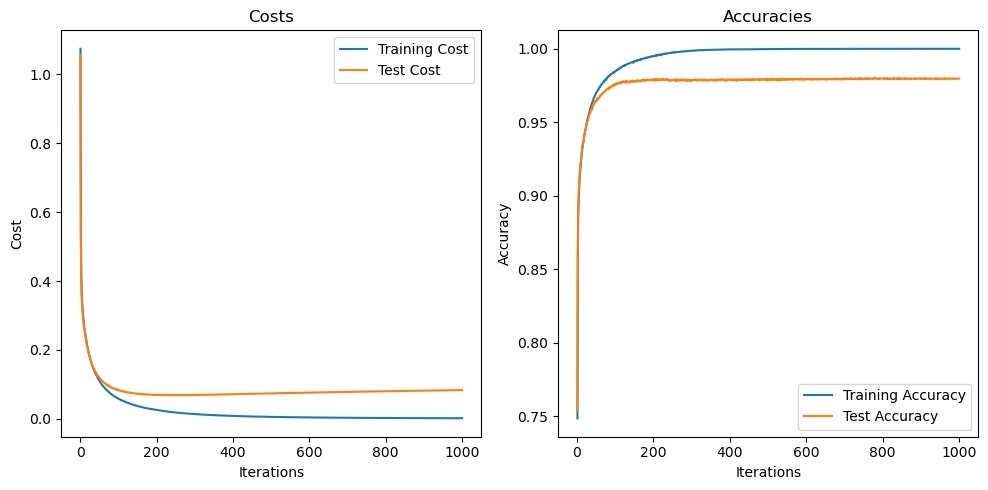

In [2]:
import matplotlib.pyplot as plt

# Function to plot training curves
def plot_training_curves(costs_train, costs_test, accuracies_train, accuracies_test):
    iterations = range(1, len(costs_train) + 1)
    
    # Plot costs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(iterations, costs_train, label='Training Cost')
    plt.plot(iterations, costs_test, label='Test Cost')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Costs')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(iterations, accuracies_train, label='Training Accuracy')
    plt.plot(iterations, accuracies_test, label='Test Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_curves(costs_train, costs_test, accuracies_train, accuracies_test)


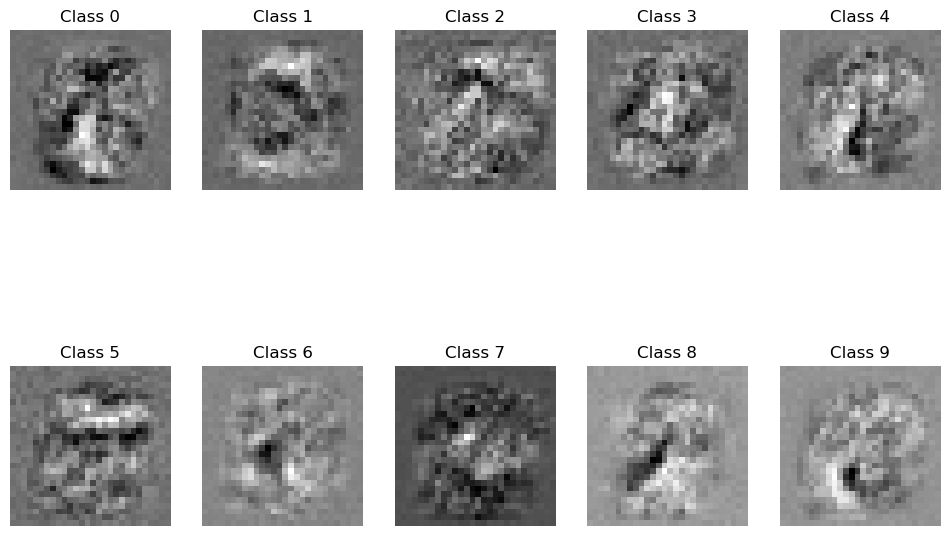

In [3]:
# Extract and visualize weights for each class
def visualize_weights(parameters):
    W = parameters['W1']  
    plt.figure(figsize=(12, 8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(W[i].reshape(28, 28), cmap='gray')
        plt.title(f'Class {i}')
        plt.axis('off')
    plt.show()

# Visualize weights
visualize_weights(parameters)


Final Train Accuracy: 1.0, Final Test Accuracy: 0.9798


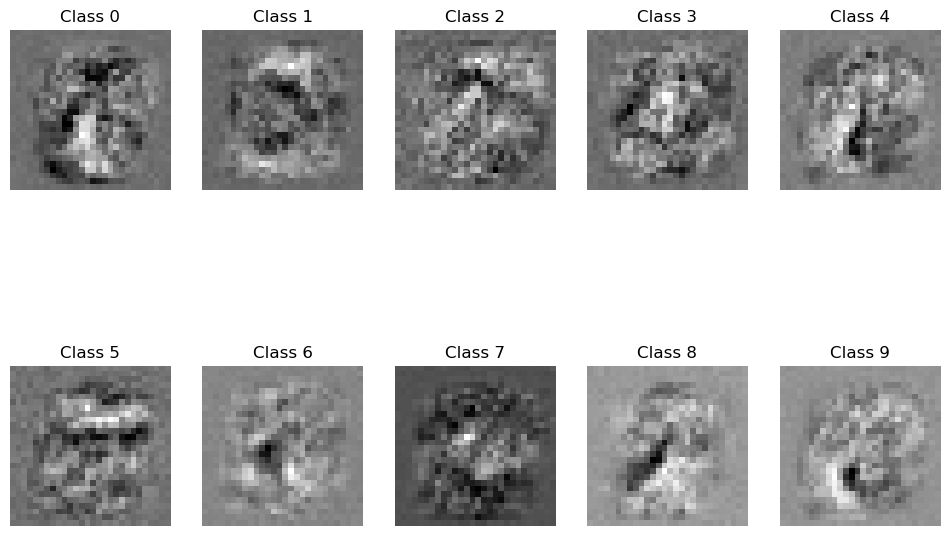

In [4]:
print(f"Final Train Accuracy: {accuracies_train[-1]}, Final Test Accuracy: {accuracies_test[-1]}")

# Visualize weights
visualize_weights(parameters)


# Implement and evaluate a multi-layer feed forward neural network

Iteration 10: Train Cost: 2.300835866818847, Test Cost: 2.3007085523339623, Train Accuracy: 0.11236666666666667, Test Accuracy: 0.1135
Iteration 20: Train Cost: 0.7970785839893273, Test Cost: 0.7900433157229857, Train Accuracy: 0.7256333333333334, Test Accuracy: 0.7292
Iteration 30: Train Cost: 0.2287083213088304, Test Cost: 0.2592425207520867, Train Accuracy: 0.9374666666666667, Test Accuracy: 0.9309
Iteration 40: Train Cost: 0.11912535707398139, Test Cost: 0.17297973413975365, Train Accuracy: 0.9671, Test Accuracy: 0.9539
Iteration 50: Train Cost: 0.056996539733252256, Test Cost: 0.14339725953584775, Train Accuracy: 0.9847833333333333, Test Accuracy: 0.9637
Iteration 60: Train Cost: 0.026523346163980065, Test Cost: 0.1384858945730302, Train Accuracy: 0.9951, Test Accuracy: 0.9665
Iteration 70: Train Cost: 0.01658468251215996, Test Cost: 0.15265785306853372, Train Accuracy: 0.9973333333333333, Test Accuracy: 0.9655
Iteration 80: Train Cost: 0.007616415931597488, Test Cost: 0.161971161

C:\Users\HP\AppData\Local\Temp\ipykernel_18960\3694974670.py:122: RuntimeWarning: invalid value encountered in divide
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))


Iteration 90: Train Cost: 0.003739476232008471, Test Cost: 0.16879369643476272, Train Accuracy: 0.99995, Test Accuracy: 0.9678
Iteration 100: Train Cost: 0.0024607642249835676, Test Cost: 0.17745380696441063, Train Accuracy: 0.9999833333333333, Test Accuracy: 0.9677
Iteration 110: Train Cost: 0.0017941015375349026, Test Cost: 0.1852502375969869, Train Accuracy: 1.0, Test Accuracy: 0.9678
Iteration 120: Train Cost: 0.0013999849563987574, Test Cost: 0.1902673538163611, Train Accuracy: 1.0, Test Accuracy: 0.9676
Iteration 130: Train Cost: 0.001124935737149754, Test Cost: 0.19642788373111708, Train Accuracy: 1.0, Test Accuracy: 0.9677
Iteration 140: Train Cost: 0.0009266966549810279, Test Cost: 0.2002711704148355, Train Accuracy: 1.0, Test Accuracy: 0.9677
Iteration 150: Train Cost: 0.0008004884754428641, Test Cost: 0.20477551893170104, Train Accuracy: 1.0, Test Accuracy: 0.9678
Iteration 160: Train Cost: 0.0006876961570416316, Test Cost: 0.20743595216025765, Train Accuracy: 1.0, Test Accu

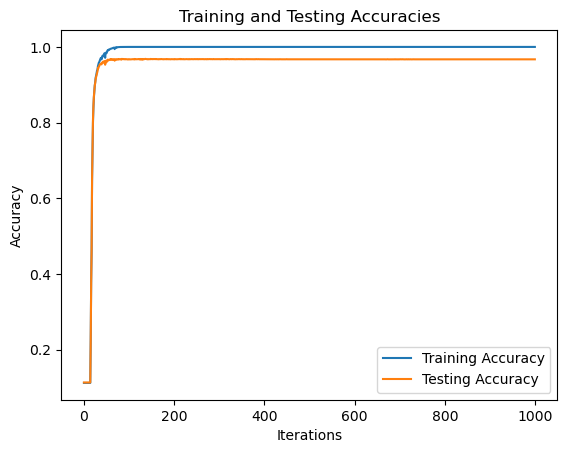

Final Train Accuracy: 1.0, Final Test Accuracy: 0.9672


In [5]:
import matplotlib.pyplot as plt

# Define the architecture of the neural network
layer_dims = [784, 256, 128, 64, 10]  # Input layer: 784 nodes, Hidden layers: 256, 128, 64 nodes, Output layer: 10 nodes

# Define hyperparameters
iterations = 1000
learning_rate = 0.01
batch_size = 64

# Train the model
parameters, costs_train, costs_test, accuracies_train, accuracies_test = train_model(X_train.T, Y_train.T, X_test.T, Y_test.T, layer_dims, iterations, learning_rate, batch_size)

# Plotting the training and testing accuracies over iterations
plt.plot(range(iterations), accuracies_train, label='Training Accuracy')
plt.plot(range(iterations), accuracies_test, label='Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.show()

# Print final accuracies
print(f"Final Train Accuracy: {accuracies_train[-1]}, Final Test Accuracy: {accuracies_test[-1]}")
